In [104]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
from scipy.stats import uniform #for training and test splits
import statsmodels.formula.api as smf # R-like model specification
import matplotlib.pyplot as plt #2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
from sklearn.metrics import confusion_matrix
import matplotlib.ticker as ticker

!pip install fuzzywuzzy
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process 

# function from https://medium.com/@rtjeannier/combining-data-sets-with-fuzzy-matching-17efcb510ab2
def match_name(name, list_names, min_score=0):
    # -1 score incase we don't get any matches
    max_score = -1
    # Returning empty name for no match as well
    max_name = ""
    # Iternating over all names in the other
    for name2 in list_names:
        #Finding fuzzy match score
        score = fuzz.ratio(name, name2)
        # Checking if we are above our threshold and have a better score
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

In [20]:
# provided coaches9.csv file for starting analysis. 
# read in Coaches data and create data frame

Coaches = pd.read_csv("https://raw.githubusercontent.com/jmchobot/IST_718_lab1/master/Coaches9.csv", error_bad_lines=False)


# Coaches = pd.read_csv("Coaches9.csv")
# from google.colab import files
# uploaded = files.upload()

# for fn in uploaded.keys():
# print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Coaches = Coaches.drop(columns=['AssistantPay'])
  
# removing data where we don't have school pay. since this is what we are predicting
Coaches = Coaches[Coaches.SchoolPay != '--']
  
print(Coaches.describe())
print(Coaches.head())

                   School Conference        Coach   SchoolPay    TotalPay  \
count                 125        125          125         125         125   
unique                125         11          125         103         104   
top     Appalachian State        ACC  Dino Babers  3500000.00  3500000.00   
freq                    1         14            1           5           5   

       Bonus BonusPaid Buyout  
count    125       125    125  
unique    85        51    102  
top       --        --     --  
freq      18        37     18  
                  School Conference              Coach   SchoolPay  \
0              Air Force   Mt. West       Troy Calhoun   885000.00   
1                  Akron        MAC       Terry Bowden   411000.00   
2                Alabama        SEC         Nick Saban  8307000.00   
3  Alabama at Birmingham      C-USA         Bill Clark   900000.00   
4      Appalachian State   Sun Belt  Scott Satterfield   712500.00   

     TotalPay       Bonus  BonusP

In [21]:
# 2006 football record by school
# http://football.stassen.com/cgi-bin/records/calc-wp.pl?start=2006&end=2006&rpct=30&min=5&se=on&by=Win+Pct

Record = pd.read_csv("https://raw.githubusercontent.com/jmchobot/IST_718_lab1/master/2006teamRecords.csv", error_bad_lines=False)

Record['School'] = Record['Team name']
Record['Win_Percent'] = Record['Winning Percentage']
Record = Record.drop(columns=['Team name', 'Winning Percentage'])


# code inspired by post: https://medium.com/@rtjeannier/combining-data-sets-with-fuzzy-matching-17efcb510ab2
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in Record.School:
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, Coaches.School, 80)
    
    # New dict for storing data
    dict_ = {}
    dict_.update({"School" : name})
    dict_.update({"match_name_Record" : match[0]})
    dict_.update({"Fuzzy_Score_Record" : match[1]})
    dict_list.append(dict_)
    
merge_table = pd.DataFrame(dict_list)
# Display results
# print(merge_table)

Record = pd.merge(Record, merge_table, how = 'left', on=['School'])
Record['School_Record'] = Record['School']
Record = Record.drop(columns=['School'])

print(Record.head())
print(Record.describe())

  Rank  Games Won  Games Lost  Games Tied  Games Played  Win_Percent  \
0    1         13           0           0            13      1.00000   
1    2         13           1           0            14      0.92857   
2   3t         12           1           0            13      0.92308   
3   3t         12           1           0            13      0.92308   
4   3t         12           1           0            13      0.92308   

   Fuzzy_Score_Record match_name_Record School_Record  
0                 100       Boise State   Boise State  
1                 100           Florida       Florida  
2                 100         Wisconsin     Wisconsin  
3                 100        Ohio State    Ohio State  
4                 100        Louisville    Louisville  
        Games Won  Games Lost  Games Tied  Games Played  Win_Percent  \
count  119.000000  119.000000       119.0    119.000000   119.000000   
mean     6.504202    6.058824         0.0     12.563025     0.506117   
std      3.2282

In [26]:
# current stadium size
# https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_stadiums

# note that this data was cleaned partially in MS Excel to ensure UTF-8 compliance

Stadium = pd.read_csv("https://raw.githubusercontent.com/jmchobot/IST_718_lab1/master/currentStadiumSize.csv", error_bad_lines=False)

Stadium['School'] = Stadium['Team']
Stadium = Stadium.drop(columns=['Team'])

Stadium['Conference_Stadium'] = Stadium['Conference']
Stadium = Stadium.drop(columns=['Conference'])

Stadium['Capacity_Thousands'] = Stadium['Capacity'] / 1000

# code inspired by post: https://medium.com/@rtjeannier/combining-data-sets-with-fuzzy-matching-17efcb510ab2
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in Stadium.School:
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, Coaches.School, 80)
    
    # New dict for storing data
    dict_ = {}
    dict_.update({"School" : name})
    dict_.update({"match_name_Stadium" : match[0]})
    dict_.update({"Fuzzy_Score_Stadium" : match[1]})
    dict_list.append(dict_)
    
merge_table = pd.DataFrame(dict_list)
# Display results
# print(merge_table)

Stadium = pd.merge(Stadium, merge_table, how = 'left', on=['School'])
Stadium['School_Stadium'] = Stadium['School']
Stadium = Stadium.drop(columns=['School'])

print(Stadium.head())
print(Stadium.describe())

                                  Stadium         City State  Capacity  \
0                  Aggie Memorial Stadium   Las Cruces    NM     30343   
1                               Alamodome  San Antonio    TX     65000   
2  Alaska Airlines Field at Husky Stadium      Seattle    WA     70500   
3                      Albertsons Stadium        Boise    ID     36387   
4                Allen E. Paulson Stadium   Statesboro    GA     25000   

  Record1  Built Expanded                        Surface Conference_Stadium  \
0   32993   1978     2005            S5-M Synthetic Turf        Independent   
1   56743   1993      NaN                     SportField              C-USA   
2   76125   1920     2013                      FieldTurf             Pac-12   
3   36864   1970     2012                     Smurf Turf      Mountain West   
4   25735   1984     2014  Shaw Legion 41 Synthetic Turf           Sun Belt   

   Capacity_Thousands  Fuzzy_Score_Stadium match_name_Stadium  \
0              

In [31]:
# NCAA graduation rates data
# http://www.ncaa.org/about/resources/research/shared-ncaa-research-data

Graduation = pd.read_csv("https://raw.githubusercontent.com/jmchobot/IST_718_lab1/master/SchoolGraduationRatesDiv1.csv", error_bad_lines=False)

GradClean = Graduation[["SCL_NAME","SCL_DIVISION","DIV1_FB_CONFERENCE","SCL_PRIVATE","GSR_N_2005_SA","GSR_2005_SA",\
                        "GSR_MALE_2005_SA","FED_N_2005_SA","FED_RATE_2005_SA","FED_RATE_MALE_2005_SA"]]

# GradClean['SCL_NAME']= GradClean['SCL_NAME'].str.split("University", n = 1, expand = True) 
GradClean['SCL_NAME'] = GradClean['SCL_NAME'].str.replace(' University','')
GradClean['SCL_NAME'] = GradClean['SCL_NAME'].str.replace('University of ','')

# print(GradClean['SCL_NAME'])

GradClean['School'] = GradClean['SCL_NAME']
GradClean = GradClean.drop(columns=['SCL_NAME'])

GradClean['Conference_Grad'] = GradClean['DIV1_FB_CONFERENCE']
GradClean = GradClean.drop(columns=['DIV1_FB_CONFERENCE'])

# code inspired by post: https://medium.com/@rtjeannier/combining-data-sets-with-fuzzy-matching-17efcb510ab2
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in GradClean.School:
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, Coaches.School, 80)
    
    # New dict for storing data
    dict_ = {}
    dict_.update({"School" : name})
    dict_.update({"match_name_Grad" : match[0]})
    dict_.update({"Fuzzy_Score_Grad" : match[1]})
    dict_list.append(dict_)
    
merge_table = pd.DataFrame(dict_list)
# Display results
# print(merge_table)

GradClean = pd.merge(GradClean, merge_table, how = 'left', on=['School'])
GradClean['School_AllGrad'] = GradClean['School']
GradClean = GradClean.drop(columns=['School'])

# print(GradClean.head())
# print(GradClean.describe())

# THIS SECTION ABANDONDED IN FAVOR OF BELOW GRAD RATES

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

In [57]:
# https://web3.ncaa.org/aprsearch/gsrsearch

GradFB = pd.read_csv("https://raw.githubusercontent.com/jmchobot/IST_718_lab1/master/GraduationRatesFootball.csv", error_bad_lines=False)

GradFB['School'] = GradFB['School'].str.replace(' University','')
GradFB['School'] = GradFB['School'].str.replace('University of ','')

for i in range(len(GradFB)):
    if(GradFB.loc[i,'Conference'] == "American Athletic Conference"):
      GradFB.loc[i,'Conference_GradFB'] = 'AAC'
    elif(GradFB.loc[i,'Conference'] == "Atlantic Coast Conference"):
      GradFB.loc[i,'Conference_GradFB'] = 'ACC'  
    elif(GradFB.loc[i,'Conference'] == "Big 12 Conference"):
      GradFB.loc[i,'Conference_GradFB'] = 'Big 12'
    elif(GradFB.loc[i,'Conference'] == "Big Ten Conference"):
      GradFB.loc[i,'Conference_GradFB'] = 'Big Ten'
    elif(GradFB.loc[i,'Conference'] == "Conference USA"):
      GradFB.loc[i,'Conference_GradFB'] = 'C-USA'
    elif(GradFB.loc[i,'Conference'] == "Independent"):
      GradFB.loc[i,'Conference_GradFB'] = 'Ind.'
    elif(GradFB.loc[i,'Conference'] == "Mid-American Conference"):
      GradFB.loc[i,'Conference_GradFB'] = 'MAC'
    elif(GradFB.loc[i,'Conference'] == "Mountain West Conference"):
      GradFB.loc[i,'Conference_GradFB'] = 'Mt. West'
    elif(GradFB.loc[i,'Conference'] == "Pac-12 Conference"):
      GradFB.loc[i,'Conference_GradFB'] = 'Pac-12'
    elif(GradFB.loc[i,'Conference'] == "Southeastern Conference"):
      GradFB.loc[i,'Conference_GradFB'] = 'SEC'
    elif(GradFB.loc[i,'Conference'] == "Sun Belt Conference"):
      GradFB.loc[i,'Conference_GradFB'] = 'Sun Belt'
    else: GradFB.loc[i,'Conference_GradFB'] = 'Unknown'
    
# print(GradFB)
      
GradFB = GradFB.drop(columns =['Conference','Cohort','Sport'])

# code inspired by post: https://medium.com/@rtjeannier/combining-data-sets-with-fuzzy-matching-17efcb510ab2
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in GradFB.School:
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, Coaches.School, 80)
    
    # New dict for storing data
    dict_ = {}
    dict_.update({"School" : name})
    dict_.update({"match_name_GradFB" : match[0]})
    dict_.update({"Fuzzy_Score_GradFB" : match[1]})
    dict_list.append(dict_)
    
merge_table = pd.DataFrame(dict_list)
# Display results
# print(merge_table)

GradFB = pd.merge(GradFB, merge_table, how = 'left', on=['School'])
GradFB['School_FBgrad'] = GradFB['School']
GradFB = GradFB.drop(columns=['School'])

print(GradFB.head())
print(GradFB.describe())

  State   GSR   FGR Conference_GradFB  Fuzzy_Score_GradFB  \
0    OH  60.0  55.0               MAC                 100   
1    AL  81.0  65.0           Unknown                  -1   
2    AL  42.0  41.0           Unknown                  -1   
3    AL  44.0  46.0               SEC                 100   
4    AL  47.0  47.0             C-USA                 100   

       match_name_GradFB          School_FBgrad  
0                  Akron                  Akron  
1                                   Alabama A&M  
2                                 Alabama State  
3                Alabama                Alabama  
4  Alabama at Birmingham  Alabama at Birmingham  
              GSR         FGR  Fuzzy_Score_GradFB
count  225.000000  207.000000          226.000000
mean    65.506667   54.642512           39.256637
std     17.068434   15.474618           48.804786
min     25.000000   14.000000           -1.000000
25%     53.000000   42.000000           -1.000000
50%     63.000000   53.000000    

In [29]:
# https://www.ncaa.org/about/where-does-money-go
# https://sports.usatoday.com/ncaa/finances

FBfinances = pd.read_csv("https://raw.githubusercontent.com/jmchobot/IST_718_lab1/master/FB_finances.csv", error_bad_lines=False)
FBfinances['FinancialRank'] = FBfinances['Rank']
FBfinances = FBfinances.drop(columns=['Rank'])

FBfinances['Percent_Allocated'] = FBfinances['Percent Allocated']
FBfinances = FBfinances.drop(columns=['Percent Allocated'])

FBfinances['Conference_Finance'] = FBfinances['Conference']
FBfinances = FBfinances.drop(columns=['Conference'])

FBfinances['Total Revenue'] = FBfinances['Total Revenue'].str.replace('$','')
FBfinances['Total Allocated'] = FBfinances['Total Allocated'].str.replace('$','')
FBfinances['Total Expenses'] = FBfinances['Total Expenses'].str.replace('$','')

FBfinances['Total Revenue'] = FBfinances['Total Revenue'].str.replace(',','')
FBfinances['Total Allocated'] = FBfinances['Total Allocated'].str.replace(',','')
FBfinances['Total Expenses'] = FBfinances['Total Expenses'].str.replace(',','')

# code inspired by post: https://medium.com/@rtjeannier/combining-data-sets-with-fuzzy-matching-17efcb510ab2
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in FBfinances.School:
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, Coaches.School, 80)
    
    # New dict for storing data
    dict_ = {}
    dict_.update({"School" : name})
    dict_.update({"match_name_finance" : match[0]})
    dict_.update({"Fuzzy_Score_finance" : match[1]})
    dict_list.append(dict_)
    
merge_table = pd.DataFrame(dict_list)
# Display results
# print(merge_table)

FBfinances = pd.merge(FBfinances, merge_table, how = 'left', on=['School'])
FBfinances['School_finance'] = FBfinances['School']
FBfinances = FBfinances.drop(columns=['School'])

print(FBfinances.head())
print(FBfinances.describe())


  Total Revenue Total Expenses Total Allocated  FinancialRank  \
0     59577780       50112617        33339247              55   
1     35331217       33895809        24641163              81   
2    174307419      158646962         2938948               5   
3      3293950        9466448          342723             230   
4     24795218       23803547        15480428             124   

   Percent_Allocated Conference_Finance  Fuzzy_Score_finance  \
0              55.96           Mt. West                  100   
1              69.74                MAC                  100   
2               1.69                SEC                  100   
3              10.40               SWAC                   -1   
4              62.43              C-USA                  100   

      match_name_finance         School_finance  
0              Air Force              Air Force  
1                  Akron                  Akron  
2                Alabama                Alabama  
3                       

In [0]:
# join the datasets together to create one usable set. 

datafuzzy = pd.merge(Coaches, Record, how = 'left', left_on=['School'], right_on=['match_name_Record'])
datafuzzy = pd.merge(datafuzzy, Stadium, how = 'left', left_on=['School','Conference'], right_on=['match_name_Stadium','Conference_Stadium'])
datafuzzy = pd.merge(datafuzzy, GradFB, how = 'left', left_on=['School','Conference'], right_on=['match_name_GradFB','Conference_GradFB'])
datafuzzy = pd.merge(datafuzzy, FBfinances, how = 'left', left_on=['School','Conference'], right_on=['match_name_finance','Conference_Finance'])

data = pd.merge(Coaches, Record, how = 'left', left_on=['School'], right_on=['School_Record'])
data = pd.merge(data, Stadium, how = 'left', left_on=['School','Conference'], right_on=['School_Stadium','Conference_Stadium'])
data = pd.merge(data, GradFB, how = 'left', left_on=['School','Conference'], right_on=['School_FBgrad','Conference_GradFB'])
data = pd.merge(data, FBfinances, how = 'left', left_on=['School','Conference'], right_on=['School_finance','Conference_Finance'])

# print(data.head())
# print(data.describe())

# use this to download off of colab to local file. 
data.to_csv('data.csv')
datafuzzy.to_csv('datafuzzy.csv')

# the fuzzy data created tons of duplicates.
# just joining on exact matches doesn't have a huge difference in data loss

In [80]:
# to make analysis easier, load in the .csv file created in last chunk. 
data = pd.read_csv("https://raw.githubusercontent.com/jmchobot/IST_718_lab1/master/data.csv", error_bad_lines=False)
datafuzzy = pd.read_csv("https://raw.githubusercontent.com/jmchobot/IST_718_lab1/master/datafuzzy.csv", error_bad_lines=False)

print(data['Fuzzy_Score_Record'].isna().sum())
print(data['Fuzzy_Score_Stadium'].isna().sum())
print(data['Fuzzy_Score_GradFB'].isna().sum())
print(data['Fuzzy_Score_finance'].isna().sum())
print('___________')
print(datafuzzy['Fuzzy_Score_Record'].isna().sum())
print(datafuzzy['Fuzzy_Score_Stadium'].isna().sum())
print(datafuzzy['Fuzzy_Score_GradFB'].isna().sum())
print(datafuzzy['Fuzzy_Score_finance'].isna().sum())

data = datafuzzy
# fuzzy data gains us a handful more records. but not much.

21
38
69
20
___________
19
37
61
20


In [0]:
data['SchoolPay_Millions'] = data['SchoolPay'] / 1000000
data['CostPerWin'] = data['SchoolPay_Millions'] / data['Games Won']
data['Total_Revenue_Millions'] = data['Total Revenue'] / 1000000
data['Total_Expenses_Millions'] = data['Total Expenses'] / 1000000
data['Total_Allocated_Millions'] = data['Total Allocated'] / 1000000

In [0]:
# corrData = data.loc[:,['SchoolPay','Games Won', 'Win Percent', 'Capacity', 'GSR_MALE_2005_SA', 'FED_RATE_MALE_2005_SA']]
# print(corrData.head())

# plt.matshow(corrData.corr(),cmap = plt.cm.Greens)

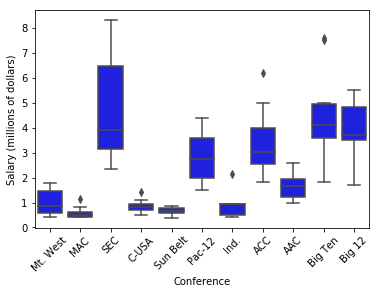

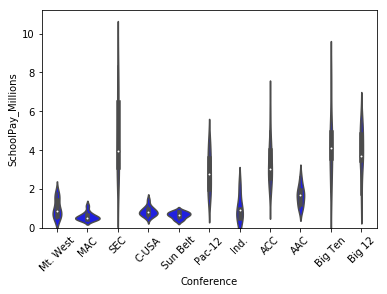

In [83]:
fig, axis = plt.subplots()

sns.boxplot(x="Conference", y="SchoolPay_Millions", data=data, color = "blue");
axis.set_xlabel('Conference')
axis.set_ylabel('Salary (millions of dollars)')
plt.xticks(rotation=45)
plt.show()

sns.violinplot(x="Conference", y="SchoolPay_Millions", data=data, color = "blue");
axis.set_xlabel('Conference')
axis.set_ylabel('Salary (millions of dollars)')
plt.ylim(0, None)
plt.xticks(rotation=45)
plt.show()


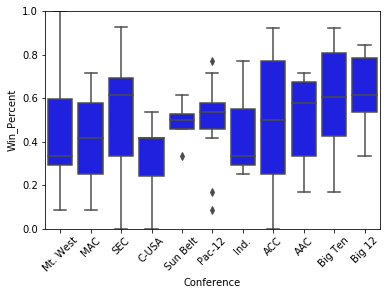

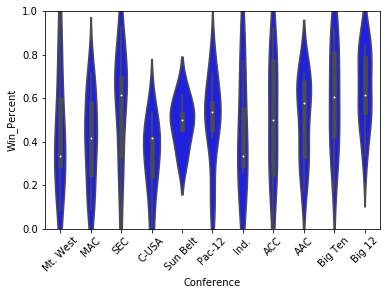

In [84]:
sns.boxplot(x='Conference', y='Win_Percent', data=data, color = 'blue');
axis.set_xlabel('Conference')
axis.set_ylabel('Win Percent')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

sns.violinplot(x='Conference', y='Win_Percent', data=data, color = 'blue');
axis.set_xlabel('Conference')
axis.set_ylabel('Win Percent')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

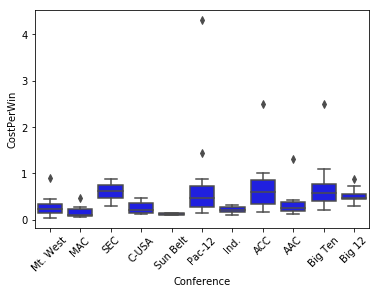

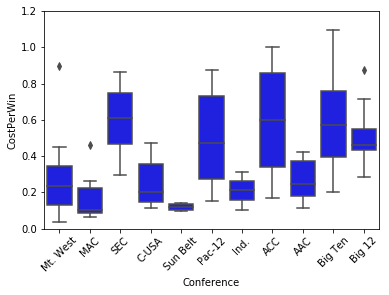

In [85]:
sns.boxplot(x='Conference', y='CostPerWin', data=data, color = 'blue');
axis.set_xlabel('Conference')
axis.set_ylabel('Coach Pay per Victory')
plt.xticks(rotation=45)
plt.show()

sns.boxplot(x='Conference', y='CostPerWin', data=data, color = 'blue');
axis.set_xlabel('Conference')
axis.set_ylabel('Coach Pay per Victory')
plt.ylim(0, 1.2)
plt.xticks(rotation=45)
plt.show()



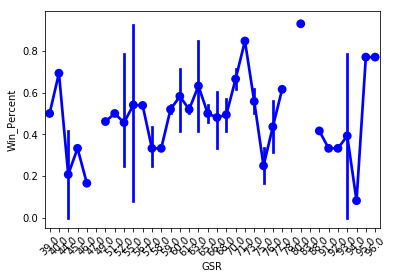

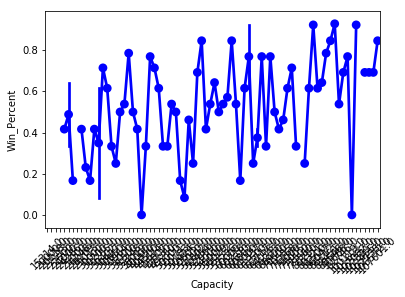

In [86]:
sns.pointplot(x='GSR', y='Win_Percent', data=data, color = 'blue');
axis.set_xlabel('Graduation Rate of Football Players')
axis.set_ylabel('Percent of Football Games Won')
plt.xticks(rotation=45)
plt.show()

sns.pointplot(x='Capacity', y='Win_Percent', data=data, color = 'blue');
axis.set_xlabel('Stadium Capacity')
axis.set_ylabel('Percent of Football Games Won')
plt.xticks(rotation=45)
plt.show()

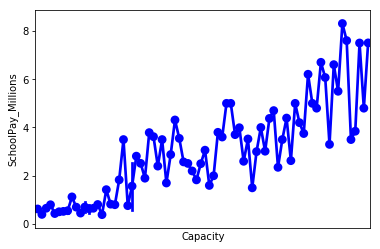

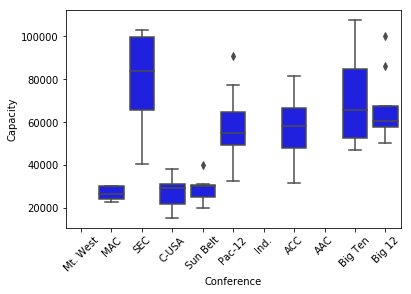

In [110]:
ax = plt.subplots()

sns.pointplot(x='Capacity', y='SchoolPay_Millions', data=data, color = 'blue');
axis.set_xlabel('Stadium Capacity')
axis.set_ylabel('Coach Salary in Millions')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

sns.boxplot(x='Conference', y='Capacity', data=data, color = 'blue');
axis.set_xlabel('Conference')
axis.set_ylabel('Stadium Capacity')
plt.xticks(rotation=45)
plt.show()

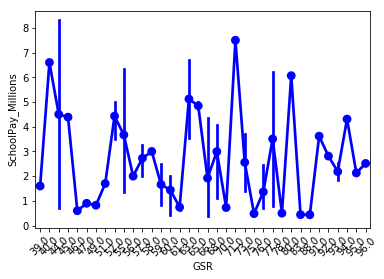

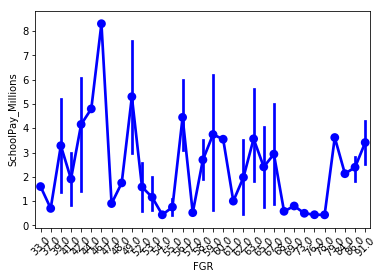

In [108]:
sns.pointplot(x='GSR', y='SchoolPay_Millions', data=data, color = 'blue');
axis.set_xlabel('Graduation Sucess Rate of Football Players')
axis.set_ylabel('Coach Salary in Millions')
plt.xticks(rotation=45)
plt.show()

sns.pointplot(x='FGR', y='SchoolPay_Millions', data=data, color = 'blue');
axis.set_xlabel('Graduation Sucess Rate of Football Players')
axis.set_ylabel('Coach Salary in Millions')
plt.xticks(rotation=45)
plt.show()

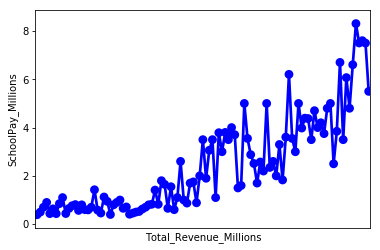

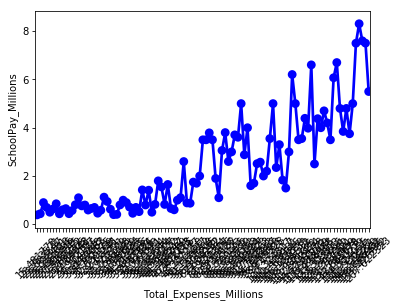

In [111]:
sns.pointplot(x='Total_Revenue_Millions', y='SchoolPay_Millions', data=data, color = 'blue');
axis.set_xlabel('Football Program Revenue')
axis.set_ylabel('Coach Salary in Millions')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

sns.pointplot(x='Total_Expenses_Millions', y='SchoolPay_Millions', data=data, color = 'blue');
axis.set_xlabel('Football Program Expenses')
axis.set_ylabel('Coach Salary in Millions')
plt.xticks(rotation=45)
plt.show()

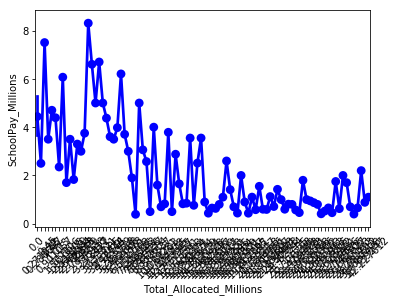

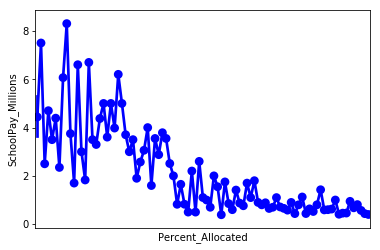

In [112]:
sns.pointplot(x='Total_Allocated_Millions', y='SchoolPay_Millions', data=data, color = 'blue');
axis.set_xlabel('Football Program Allocation')
axis.set_ylabel('Coach Salary in Millions')
plt.xticks(rotation=45)
plt.show()

sns.pointplot(x='Percent_Allocated', y='SchoolPay_Millions', data=data, color = 'blue');
axis.set_xlabel('Football Program Allocation Percent')
axis.set_ylabel('Coach Salary in Millions')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xticks(rotation=45)
plt.show()

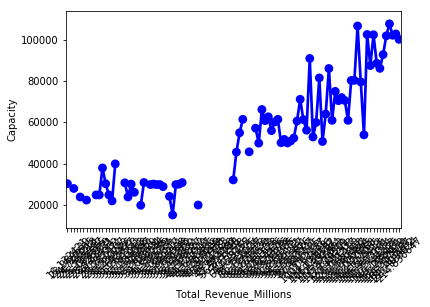

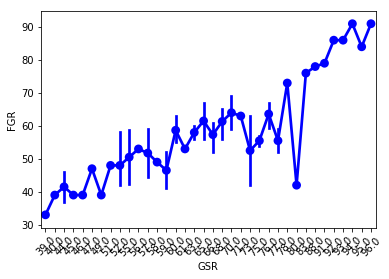

In [72]:
sns.pointplot(x='Total_Revenue_Millions', y='Capacity', data=data, color = 'blue');
axis.set_xlabel('Football Program Revenue')
axis.set_ylabel('Stadium Capacity')
plt.xticks(rotation=45)
plt.show()

sns.pointplot(x='GSR', y='FGR', data=data, color = 'blue');
axis.set_xlabel('GSR')
axis.set_ylabel('FGR')
plt.xticks(rotation=45)
plt.show()

In [113]:
# employ training-and-test regimen for model validation
np.random.seed(1235)
data['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(data))
data_train = data[data['runiform'] >= 0.33]
data_test = data[data['runiform'] < 0.33]
# check training data frame
print('\ndata_train data frame (rows, columns): ',data_train.shape)
# print(data_train.head())

# check test data frame
print('\ndata_test data frame (rows, columns): ',data_test.shape)
# print(data_test.head())


data_train data frame (rows, columns):  (86, 53)

data_test data frame (rows, columns):  (39, 53)


In [121]:
# specify a simple model
my_model = str("SchoolPay_Millions ~ Capacity + Conference")
# win percent bad predictor - w/ HDI crossing zero
# private or public school bad predictor - w/ HDI crossing zero
# only certain conferences are significant
# percent allocated barely raises R-squared and is not signfiicant. strange
# total revenue and capacity likely have coliniarity. rich program has big stadium

# fit the model to the training set
train_model_fit = smf.ols(my_model, data = data_train, missing = 'drop').fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
data_train['predict_salary'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
data_test['predict_salary'] = train_model_fit.predict(data_test)
data_test['Prediction_Difference'] = data_test['predict_salary'] - data_test['SchoolPay_Millions']

print(data_test['Prediction_Difference'].describe())

print(data_test.loc[:,['School','SchoolPay_Millions','predict_salary']])

                            OLS Regression Results                            
Dep. Variable:     SchoolPay_Millions   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     26.93
Date:                Sat, 20 Apr 2019   Prob (F-statistic):           1.48e-16
Time:                        20:32:40   Log-Likelihood:                -87.884
No. Observations:                  65   AIC:                             193.8
Df Residuals:                      56   BIC:                             213.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda